# **LSTM**

<ipython-input-10-92b9199a3a12>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_list = torch.load('/content/run1b_2018-05-29-14-02-47.kinect_color.pt')
<ipython

Final Tensor Shape: torch.Size([19071, 34])
Final Tensor Shape: torch.Size([26655, 34])
Epoch 1/100, Loss: 763.4482, Accuracy: 0.5696
Epoch 2/100, Loss: 494.5375, Accuracy: 0.6889
Epoch 3/100, Loss: 452.7228, Accuracy: 0.7092
Epoch 4/100, Loss: 426.0978, Accuracy: 0.7242
Epoch 5/100, Loss: 410.6982, Accuracy: 0.7355
Epoch 6/100, Loss: 393.6101, Accuracy: 0.7429
Epoch 7/100, Loss: 385.0960, Accuracy: 0.7512
Epoch 8/100, Loss: 376.3700, Accuracy: 0.7537
Epoch 9/100, Loss: 362.4921, Accuracy: 0.7620
Epoch 10/100, Loss: 357.7613, Accuracy: 0.7650
Epoch 11/100, Loss: 349.9273, Accuracy: 0.7704
Epoch 12/100, Loss: 343.0265, Accuracy: 0.7766
Epoch 13/100, Loss: 339.5897, Accuracy: 0.7756
Epoch 14/100, Loss: 332.9863, Accuracy: 0.7802
Epoch 15/100, Loss: 326.4660, Accuracy: 0.7842
Epoch 16/100, Loss: 321.5112, Accuracy: 0.7859
Epoch 17/100, Loss: 320.2142, Accuracy: 0.7886
Epoch 18/100, Loss: 315.4648, Accuracy: 0.7927
Epoch 19/100, Loss: 313.7195, Accuracy: 0.7931
Epoch 20/100, Loss: 309.5167

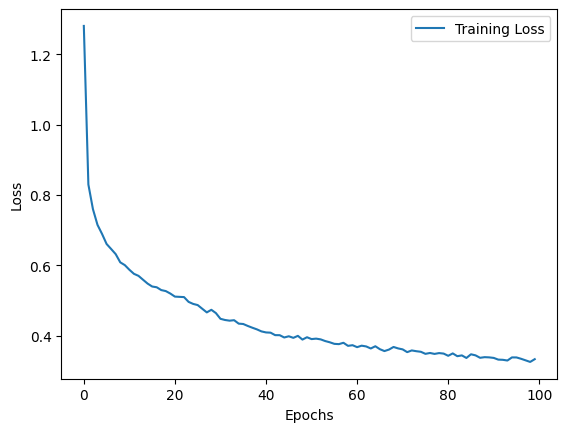

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder


# Load the .pt file (list of NumPy arrays)
train_data_list = torch.load('/content/run1b_2018-05-29-14-02-47.kinect_color.pt')

# Convert list of NumPy arrays into a single PyTorch tensor
train_tensor = torch.tensor(np.stack(train_data_list))  # Shape: (19071, 34)

# Print final tensor shape to confirm
print(f"Final Tensor Shape: {train_tensor.shape}")  # Should be (19071, 34)

test_data_list = torch.load('/content/run1_2018-05-22-15-10-41.kinect_color.pt')

# Convert list of NumPy arrays into a single PyTorch tensor
test_tensor = torch.tensor(np.stack(test_data_list))  # Shape: (19071, 34)

# Print final tensor shape to confirm
print(f"Final Tensor Shape: {test_tensor.shape}")  # Should be (19071, 34)


# Load training labels
train_labels_df = pd.read_csv('/content/training_data.csv')

# Load test data
# (Assuming similar structure as training data)
test_labels_df = pd.read_csv('/content/test_data.csv')

def process_labels(df):
    """Convert CSV labels into a format that aligns with tensor indices."""
    label_encoder = LabelEncoder()
    df['activity'] = label_encoder.fit_transform(df['activity'])  # Fix column name
    return df, label_encoder

# Apply the fix
train_labels_df, label_encoder = process_labels(train_labels_df)
test_labels_df, _ = process_labels(test_labels_df)



# Creating Dataset Class
class DriverDataset(Dataset):
    def __init__(self, tensor_data, labels_df, seq_len=10):
        self.tensor_data = tensor_data
        self.labels_df = labels_df
        self.seq_len = seq_len  # Define sequence length

    def __len__(self):
        return len(self.tensor_data) - self.seq_len  # Ensure valid sequences

    def __getitem__(self, idx):
        feature_seq = self.tensor_data[idx:idx + self.seq_len]  # Get a sequence
        label = self.labels_df.iloc[idx + self.seq_len - 1]['activity']  # Align label with last frame
        return feature_seq, label


# Create DataLoader
train_dataset = DriverDataset(train_tensor, train_labels_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = DriverDataset(test_tensor, test_labels_df)  # Use test_tensor
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Now x is (batch_size, seq_len, input_dim)
        out = self.fc(lstm_out[:, -1, :])  # Use last time step output
        return out


# Model Initialization
input_dim = 34
hidden_dim = 128
output_dim = len(label_encoder.classes_)
model = LSTMModel(input_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    return train_losses

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer)

# Plot Training Loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
def test_model(model, test_loader):
    """Evaluate model on test data and print accuracy."""
    model.eval()
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            predicted = outputs.argmax(1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            predictions.extend(predicted.cpu().numpy())  # Store predictions for visualization

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    return predictions

# Run the test evaluation
test_predictions = test_model(model, test_loader)

# Print sample frame-wise predictions
print("\nSample Frame-wise Predictions:")
for i in range(1000):  # Print first 10 predictions
    print(f"Frame {i}: Predicted Action - {label_encoder.inverse_transform([test_predictions[i]])[0]}")


Test Accuracy: 22.30%

Sample Frame-wise Predictions:
Frame 0: Predicted Action - nan
Frame 1: Predicted Action - nan
Frame 2: Predicted Action - nan
Frame 3: Predicted Action - nan
Frame 4: Predicted Action - nan
Frame 5: Predicted Action - placing_an_object
Frame 6: Predicted Action - nan
Frame 7: Predicted Action - nan
Frame 8: Predicted Action - placing_an_object
Frame 9: Predicted Action - nan
Frame 10: Predicted Action - nan
Frame 11: Predicted Action - nan
Frame 12: Predicted Action - nan
Frame 13: Predicted Action - entering_car
Frame 14: Predicted Action - entering_car
Frame 15: Predicted Action - entering_car
Frame 16: Predicted Action - entering_car
Frame 17: Predicted Action - entering_car
Frame 18: Predicted Action - entering_car
Frame 19: Predicted Action - entering_car
Frame 20: Predicted Action - entering_car
Frame 21: Predicted Action - entering_car
Frame 22: Predicted Action - entering_car
Frame 23: Predicted Action - entering_car
Frame 24: Predicted Action - entering

# **Transformers**

<ipython-input-18-7a55d7df1fe0>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_list = torch.load('/content/run1b_2018-05-29-14-02-47.kinect_color.pt')
<ipython

Epoch 1/100, Loss: 1238.1222, Training Accuracy: 0.2598
Validation Loss: 2.5133, Validation Accuracy: 0.2848
Epoch 2/100, Loss: 1215.4287, Training Accuracy: 0.2583
Validation Loss: 2.4838, Validation Accuracy: 0.2848
Epoch 3/100, Loss: 1209.3610, Training Accuracy: 0.2627
Validation Loss: 2.4812, Validation Accuracy: 0.2848
Epoch 4/100, Loss: 1207.3969, Training Accuracy: 0.2642
Validation Loss: 2.4843, Validation Accuracy: 0.2848
Epoch 5/100, Loss: 1206.0137, Training Accuracy: 0.2631
Validation Loss: 2.4916, Validation Accuracy: 0.2848
Epoch 6/100, Loss: 1205.6849, Training Accuracy: 0.2613
Validation Loss: 2.4810, Validation Accuracy: 0.2848
Epoch 7/100, Loss: 1204.7101, Training Accuracy: 0.2668
Validation Loss: 2.4865, Validation Accuracy: 0.2848
Epoch 8/100, Loss: 1204.6721, Training Accuracy: 0.2651
Validation Loss: 2.4996, Validation Accuracy: 0.2331
Epoch 9/100, Loss: 1204.5683, Training Accuracy: 0.2650
Validation Loss: 2.4840, Validation Accuracy: 0.2848
Epoch 10/100, Loss:

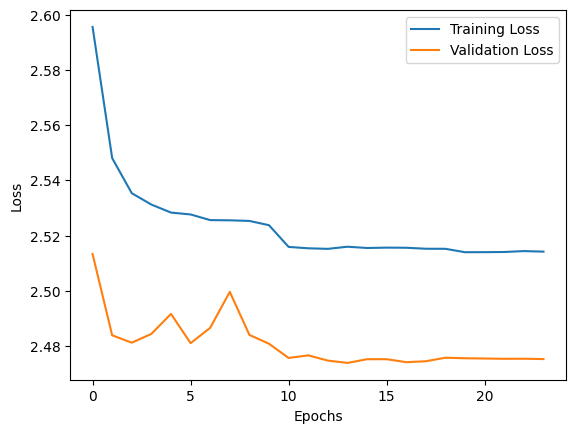

<ipython-input-18-7a55d7df1fe0>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.2059


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the .pt file (list of NumPy arrays)
train_data_list = torch.load('/content/run1b_2018-05-29-14-02-47.kinect_color.pt')
test_data_list = torch.load('/content/run1_2018-05-22-15-10-41.kinect_color.pt')

# Convert list of NumPy arrays into a single PyTorch tensor
train_tensor = torch.tensor(np.stack(train_data_list))  # Shape: (19071, 34)
test_tensor = torch.tensor(np.stack(test_data_list))  # Shape: (19071, 34)

# Normalize the data
scaler = StandardScaler()
train_tensor = torch.tensor(scaler.fit_transform(train_tensor))
test_tensor = torch.tensor(scaler.transform(test_tensor))

# Load training and test labels
train_labels_df = pd.read_csv('/content/training_data.csv')
test_labels_df = pd.read_csv('/content/test_data.csv')

def process_labels(df):
    """Convert CSV labels into a format that aligns with tensor indices."""
    label_encoder = LabelEncoder()
    df['activity'] = label_encoder.fit_transform(df['activity'])
    return df, label_encoder

# Apply the fix
train_labels_df, label_encoder = process_labels(train_labels_df)
test_labels_df, _ = process_labels(test_labels_df)

# Creating Dataset Class
class DriverDataset(Dataset):
    def __init__(self, tensor_data, labels_df, seq_len=10):
        self.tensor_data = tensor_data
        self.labels_df = labels_df
        self.seq_len = seq_len  # Define sequence length

    def __len__(self):
        return len(self.tensor_data) - self.seq_len  # Ensure valid sequences

    def __getitem__(self, idx):
        feature_seq = self.tensor_data[idx:idx + self.seq_len]  # Get a sequence
        label = self.labels_df.iloc[idx + self.seq_len - 1]['activity']  # Align label with last frame
        return feature_seq, label

# Create Dataset and DataLoader
train_dataset = DriverDataset(train_tensor, train_labels_df)
test_dataset = DriverDataset(test_tensor, test_labels_df)

# Split train_dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=512, nhead=8, num_encoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = self._generate_positional_encoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:x.size(1), :].to(x.device)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

    def _generate_positional_encoding(self, d_model):
        max_seq_length = 300  # Adjust this value to match your input sequence length
        pos = torch.arange(max_seq_length).unsqueeze(1)
        i = torch.arange(d_model).unsqueeze(0)
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / d_model)
        positional_encoding = pos * angle_rates
        positional_encoding[:, 0::2] = torch.sin(positional_encoding[:, 0::2])
        positional_encoding[:, 1::2] = torch.cos(positional_encoding[:, 1::2])
        return positional_encoding

# Model Initialization
input_dim = 34
d_model = 512
num_classes = len(label_encoder.classes_)
model = TransformerModel(input_dim, num_classes, d_model=d_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop with Validation and Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()  # Ensure model is in training mode
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.4f}")

        # Validation
        model.eval()  # Ensure model is in evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.float())
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

        scheduler.step()

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Plot Training and Validation Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Load the best model and test
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)
